In [34]:
from keras import layers
from keras import Model
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
import shutil
import numpy as np
from PIL import Image
import onnxruntime as ort

In [12]:
base_dir = 'data'
train_dir = os.path.join(base_dir, 'train')
train_dir_dogs = os.path.join(base_dir, 'train/dogs')
train_dir_cats = os.path.join(base_dir, 'train/cats')

validation_dir = os.path.join(base_dir, 'validation')
validation_dir_dogs = os.path.join(base_dir, 'validation/dogs')
validation_dir_cats = os.path.join(base_dir, 'validation/cats')

In [4]:
print('total training cat images:', len(os.listdir(train_dir_cats)))
print('total training dog images:', len(os.listdir(train_dir_dogs)))
print('total validation cat images:', len(os.listdir(validation_dir_cats)))
print('total validation dog images:', len(os.listdir(validation_dir_dogs)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


In [16]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        shuffle=True,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        shuffle=True,
        batch_size=20,
        class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [14]:
model = VGG16(include_top=False, input_shape=(150, 150, 3))
for layer in model.layers:
    layer.trainable = False

flat1 = layers.Flatten()(model.layers[-1].output)
class1 = layers.Dense(128, activation='relu')(flat1)
output = layers.Dense(2, activation='softmax')(class1)

model = Model(inputs=model.inputs, outputs=output)
opt = Adam(lr=0.01)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 6s 0us/step


/Users/eryk/miniconda3/envs/ml/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [18]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=5,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=True)

Epoch 1/5


/var/folders/p3/1mlnmr7563b2lsdz5xhg4k7w0000gn/T/ipykernel_98999/4198420037.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 [==============================] - 130s 1s/step - loss: 0.2754 - accuracy: 0.8830 - val_loss: 0.3254 - val_accuracy: 0.8660
Epoch 2/5
100/100 [==============================] - 123s 1s/step - loss: 0.1437 - accuracy: 0.9445 - val_loss: 0.2958 - val_accuracy: 0.8840
Epoch 3/5
100/100 [==============================] - 123s 1s/step - loss: 0.0782 - accuracy: 0.9715 - val_loss: 0.3424 - val_accuracy: 0.8960
Epoch 4/5
100/100 [==============================] - 124s 1s/step - loss: 0.0848 - accuracy: 0.9665 - val_loss: 0.3358 - val_accuracy: 0.8820
Epoch 5/5
100/100 [==============================] - 126s 1s/step - loss: 0.0615 - accuracy: 0.9760 - val_loss: 0.4087 - val_accuracy: 0.8710


<Figure size 640x480 with 0 Axes>

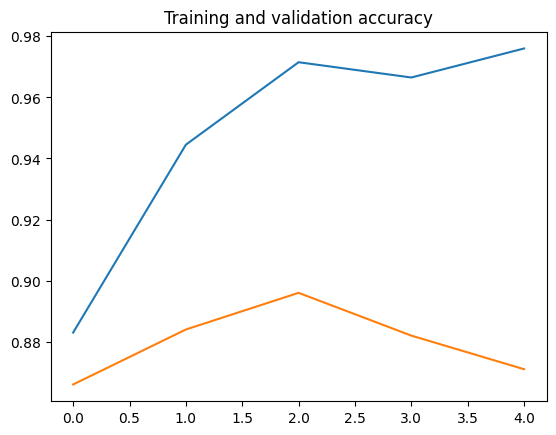

<Figure size 640x480 with 0 Axes>

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

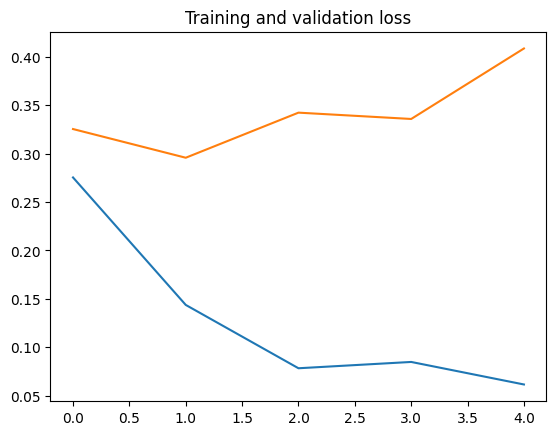

In [20]:
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.show()

In [27]:
saved_models_path="cats_dogs_saved_model"
if not os.path.isdir(saved_models_path):
      os.makedirs(saved_models_path)

model.save(saved_models_path)

INFO:tensorflow:Assets written to: cats_dogs_saved_model/assets


INFO:tensorflow:Assets written to: cats_dogs_saved_model/assets


In [28]:
shutil.make_archive(saved_models_path, 'zip', saved_models_path)

'/Users/eryk/Documents/Metody głębokiego uczenia w systemach wizyjnych i wirtualnej rzeczywistości/deep-learning-vr-uni-projects/project01/cats_dogs_saved_model.zip'

In [ ]:
# !pip install onnxruntime
# !pip install onnx
# !pip install -U tf2onnx

In [33]:
# !unzip cats_dogs_saved_model.zip -d cats_dogs_saved_model
!python -m tf2onnx.convert --saved-model ./cats_dogs_saved_model --opset 11 --output cats_dogs_saved_model.onnx

/Users/eryk/miniconda3/envs/ml/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


/Users/eryk/miniconda3/envs/ml/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2025-03-26 12:27:04,208 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2025-03-26 12:27:04,623 - INFO - Signatures found in model: [serving_default].
2025-03-26 12:27:04,623 - WARNING - '--signature_def' not specified, using first signature: serving_default
2025-03-26 12:27:04,623 - INFO - Output names: ['dense_1']
2025-03-26 12:27:05,545 - INFO - Using tensorflow=2.12.0, onnx=1.17.0, tf2onnx=1.16.1/15c810
2025-03-26 12:27:05,545 - INFO - Using opset <onnx, 11>
2025-03-26 12:27:05,680 - INFO - Computed 0 values for constant folding
2025-03-26 12:27:05,922 - INFO - Optimizing ONNX model
2025-03-26 12:27:06,532 - INFO - After optimization: Cast -1 (1->0), Identity -2 (2->0), Transpose -34 (36->2)
2025-03-

In [35]:
def classify(my_path, sess_ort):
    img = Image.open(my_path).convert('RGB').resize((150,150))
    img=np.expand_dims(np.asarray(img, dtype="float32"),axis=0)
    img=img/255
    outputs = sess_ort.run(None, {sess_ort.get_inputs()[0].name: img})
    return outputs

onnx_path = 'cats_dogs_saved_model.onnx'
sess_ort = ort.InferenceSession(onnx_path,providers=ort.get_available_providers())
print(classify("./data/validation/cats/cat.2479.jpg", sess_ort))
print(classify("./data/validation/dogs/dog.2473.jpg", sess_ort))

[array([[9.9999964e-01, 3.0233832e-07]], dtype=float32)]
[array([[0.00111384, 0.99888617]], dtype=float32)]


2025-03-26 12:28:37.899870 [W:onnxruntime:, coreml_execution_provider.cc:112 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 2 number of nodes in the graph: 38 number of nodes supported by CoreML: 36
